# Model 2

# Diabetic Retinopathy CNN Binary Model 

## Mark Whelly - BrainStation Data Science Bootcamp - August 2022

Transfer Learning Model using InceptionV3. Working on Google Colab Cloud environment.

This is the second of 5 models presented as part of this project.

This MODEL 2 is a binary classifier of retinal images, specifically looking for Diabetic Retinopathy (DR).
DR is a very prevalent eye disease associated with diabetes, and can lead to permanent blindness.
There are a number of indicators of this DR condition including microaneurysms, retinal dot and blot hemorrhage, hard exudates or cotton wool spots.

This CNN model only includes the images that show either:
    -Normal eye condition (class 0).
    -DR only (class1). No other disease present.

The data originate from a scientific paper in the journal Data, as published by Pachade et al 2021. Data was obtained from the kaggle website, as provided by the user 'Larxel' under the dataset Retinal Image Classification.

All modeling work was done on the Google Colab environment using google GPU to increase modeling speeds.

In [31]:
import os

In [32]:
from google.colab import drive

In [33]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [34]:
cd/gdrive/My Drive/Retimages/Train/

/gdrive/My Drive/Retimages/Train


In [35]:
# import libraries and packages

import numpy as np 
import pandas as pd
import zipfile

import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.python.keras.models import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from pathlib import Path
import os

import skimage
import skimage.io
from skimage import data, img_as_float
from skimage import exposure
from matplotlib import pyplot as plt

from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
from skimage.exposure import equalize_hist

In [36]:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, GRU, Bidirectional
    from tensorflow.keras.optimizers import SGD
except:
    !pip install keras
    !pip install h5py==3.1.0 numpy==1.19.2 six==1.15.0 typing-extensions==3.7.4 wrapt==1.12.1 botocore==1.20.106 gast==0.4.0 tensorboard==2.6 tensorflow-estimator==2.6 absl-py==0.9 protobuf==3.11.2 scikit-learn==0.24 fsspec==2021.07.0 google-api-python-client==1.12.1
    !pip install --upgrade tensorflow
    !pip install --ignore-installed --upgrade tensorflow-gpu==1.15.0
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
    from tensorflow.keras.optimizers import SGD

In [37]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import shutil
from tqdm import tqdm

# PART 1 - Data Preparation and Organization

Grouping images into 2 separate folders (0 for Normal photos, and 1 for DR images), within Retimages/Train/TrainDRONLY directory on Google Colab.

Similarly, Validation images were grouped into subfolder per 2 classes, within Retimages/Validation/ValidDRONLY, and Test images grouped into Retimages/Test/TestDRONLY.

Note that image preprocessing was conducted on all images and the model was run and compared with the model using the original non-enhanced images. In this case, the best results (recall, precision, accuracy) were seen with the non-enhanced images and this is shown below.

In [ ]:
# ALREADY RUN, do not rerun. 

# This code grouped images into 2 folders.

# organize images into folders based on class 0 (normal) and class 1 (1 or more 
# diseases present as hot-encoded in the csv label file
# TRAINING IMAGES READING
# 'Normal' as class 0, based on '0' in col 1 ('DisCode')
a=[] 

# DR_Only, based on a 1 in col 1.
b=[] 

# Remaining Disease combos are a 2 in col 1. (these will not be used)
#c= []

with open('../Train/TrainDR_Labels.csv','r') as F:
  reader=csv.reader(F)
  for row in reader:
      if(row[1]=='0'):  # Normal.
        a.append(row[0]+'.png')
      if(row[1]=='1'):  # DR_Only
        b.append(row[0]+'.png')
      #if(row[1])=='2'):  # Other disease cases (NOT USED)
        #c.append(row[0]+'.png')
F.close() 
os.mkdir('./TrainDRONLY')

parent_dir="./TrainDRONLY"
directory1 = "0Normal" 
directory2 = "1DRonly"
path1 = os.path.join(parent_dir, directory1)
path2 = os.path.join(parent_dir, directory2)
os.mkdir(path1)
os.mkdir(path2)

In [ ]:
# ALREADY RUN, do not rerun. 

save_path = './TrainDRONLY/0Normal'
for filename in a:
  shutil.copy('Training_set/'+filename,save_path)

save_path = './TrainDRONLY/1DRonly'
for filename in b:
  shutil.copy('Training_set/'+filename,save_path)

In [ ]:
cd/gdrive/My Drive/Retimages/Validation/

/gdrive/My Drive/Retimages/Validation


In [ ]:
# ALREADY RUN, do not rerun. 

# This code grouped images into 2 folders.

# VALIDATION IMAGES READING
# 'Normal' as class 0, based on '0' in col 1 ('DisCode'), goes in '0_Normal'
a=[]

# DR_Only, based on a 1 in col 1 ('DisCode').
b=[]

# Remaining Disease combos are a 2 in col 1. (these will not be used)

with open('../Validation/ValidDR_Labels.csv','r') as F:
  reader=csv.reader(F)
  for row in reader:
      if(row[1]=='0'):  # Normal.
        a.append(row[0]+'.png')
      if(row[1]=='1'):  # DR_Only
        b.append(row[0]+'.png')
      #if(row[1])=='2'):  # Other disease cases (NOT USED)
        #c.append(row[0]+'.png')
F.close() 
os.mkdir('./ValidDRONLY')

In [ ]:
# ALREADY RUN, do not rerun. 

parent_dir="./ValidDRONLY"
directory1 = "0Normal" 
directory2 = "1DRonly"
path1 = os.path.join(parent_dir, directory1)
path2 = os.path.join(parent_dir, directory2)
os.mkdir(path1)
os.mkdir(path2)

In [ ]:
# ALREADY RUN, do not rerun. 

save_path = './ValidDRONLY/0Normal'
for filename in a:
  shutil.copy('Validation_set/'+filename,save_path)
save_path = './ValidDRONLY/1DRonly'
for filename in b:
  shutil.copy('Validation_set/'+filename,save_path)

In [ ]:
cd/gdrive/My Drive/Retimages/Test/

/gdrive/My Drive/Retimages/Test


In [ ]:
# ALREADY RUN, do not rerun. 

# TEST IMAGES READING
# 'Normal' as class 0, based on '0' in col 1 ('DisCode')
a=[]

# DR_Only, based on a 1 in col 1.
b=[]

# Remaining Disease combos are a 2 in col 1. (these will not be used)

with open('../Test/TestDR_Labels.csv','r') as F:
  reader=csv.reader(F)
  for row in reader:
      if(row[1]=='0'):  # Normal.
        a.append(row[0]+'.png')
      if(row[1]=='1'):  # DR_Only
        b.append(row[0]+'.png')
      #if(row[1])=='2'):  # Other disease cases (NOT USED)
        #c.append(row[0]+'.png')
F.close() 
os.mkdir('./TestDRONLY')

In [ ]:
# ALREADY RUN, do not rerun. 

parent_dir="./TestDRONLY"
directory1 = "0Normal" 
directory2 = "1DRonly"
path1 = os.path.join(parent_dir, directory1)
path2 = os.path.join(parent_dir, directory2)
os.mkdir(path1)
os.mkdir(path2)

In [ ]:
# ALREADY RUN, do not rerun. 

save_path = './TestDRONLY/0Normal'
for filename in a:
  shutil.copy('Test_set/'+filename,save_path)
save_path = './TestDRONLY/1DRonly'
for filename in b:
  shutil.copy('Test_set/'+filename,save_path)

In [ ]:
# ALREADY RUN, do not rerun. 

# actual augmentation of eqh per image:
for f in all_the_files:
  img_in = cv2.imread(str(f))
  #  transformation
  img_histeq = hist_equalize(img_in)
  #writing to target folder
  cv2.imwrite(f'{destination_path}/{f.name}', img_histeq)


In [43]:
from google.colab.patches import cv2_imshow

In [44]:
cd/gdrive/My Drive/Retimages/

/gdrive/My Drive/Retimages


In [ ]:
# TO AUGMENT NUMBER OF IMAGES based on imbalanced classes:

# already run this

#  Do not rerun

from keras.preprocessing.image import ImageDataGenerator
from skimage import io
datagen = ImageDataGenerator(        
        rotation_range = 20,
        vertical_flip = True,
        horizontal_flip = True,
        brightness_range = (1, 1.4))
import numpy as np
import os
from PIL import Image

# augmenting TRAIN DRONLY set of  pics:
image_directory = os.path.join('./Test/TestDRONLY/1DRonly/')
dataset = []
my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):    
    if (image_name.split('.')[1] == 'png'):        
        image = io.imread(image_directory + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((1072,712)) 
        dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=10,
                          save_to_dir= os.path.join('./Test/TestDRONLY/Aug/'),
                          save_prefix='dr2',
                          save_format='png'):    
    i += 1    
    if i > 4:        
        break

In [45]:
# count files per group

train_abnormal_dir = os.path.join('./Train/TrainDRONLY/1DRonly')
train_normal_dir = os.path.join('./Train/TrainDRONLY/0Normal')
train_abnormal_names = os.listdir(train_abnormal_dir)
train_normal_names = os.listdir(train_normal_dir)
print('total training images with DR:', len(os.listdir(train_abnormal_dir)))
print('total training images of normal eyes:', len(os.listdir(train_normal_dir)))

total training images with DR: 410
total training images of normal eyes: 401


In [47]:
validation_abnormal_dir = os.path.join('./Validation/ValidDRONLY/1DRonly')
validation_normal_dir = os.path.join('./Validation/ValidDRONLY/0Normal')
validation_abnormal_names = os.listdir(validation_abnormal_dir)
validation_normal_names = os.listdir(validation_normal_dir)
print('total validation images with DR:', len(os.listdir(validation_abnormal_dir)))
print('total validation images of normal eyes:', len(os.listdir(validation_normal_dir)))

total validation images with DR: 131
total validation images of normal eyes: 134


In [48]:
test_abnormal_dir = os.path.join('./Test/TestDRONLY/1DRonly')
test_normal_dir = os.path.join('./Test/TestDRONLY/0Normal')
test_abnormal_names = os.listdir(test_abnormal_dir)
test_normal_names = os.listdir(test_normal_dir)
print('total Test images with DR:', len(os.listdir(test_abnormal_dir)))
print('total Test images of normal eyes:', len(os.listdir(test_normal_dir)))

total Test images with DR: 130
total Test images of normal eyes: 134


The dataset was split into train:validation:test sets with 60/20/20 ratios. The ratio of healthy to disease eye images was maintained the same in train, test and validation sets.

## Image Data Generators

In [50]:
# Original (non-equalized) images were used here.

height = 356
width = 536
BATCH_SIZE = 48

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   brightness_range=(1,1.1),
                                   zoom_range= 0.1,
                                   vertical_flip = True,
                                   horizontal_flip = True,
                                   fill_mode='constant',
                                   cval = 1)

train_generator = train_datagen.flow_from_directory('./Train/TrainDRONLY', 
                                                    target_size=(height,width), 
                                                    color_mode='rgb',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode='categorical')


Found 811 images belonging to 2 classes.


In [51]:
# define x_train and y_train from train generator: 
X_train, y_train = train_generator.next() 

In [52]:
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory('./Validation/ValidDRONLY', 
                                                              target_size=(height,width),
                                                              color_mode='rgb',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              class_mode='categorical')

Found 265 images belonging to 2 classes.


# Pretrained CNN Model

In [53]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [55]:
# load InceptionNetV3 model
model=InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(height,width,3))

# Transfer Learning Model

In [56]:
# Freeze all the layers in the base model
for layer in model.layers:
    layer.trainable = False

# remove last 2 layers of base Inceptionv3 model
front_output = model.layers[-2].output

# Dropout Layer
dl_output = Dropout(0.35)(front_output) 

# add flatten layer
flat_output = Flatten()(dl_output)

# add fully connected layers
d1 = Dense(512, activation='relu')(flat_output)
d2 = Dense(128, activation='relu')(d1)
d3 = Dense(64, activation='relu')(d2)
#d4 = Dense(64, activation='relu')(d3)
#d5 = Dense(16, activation='relu')(d4)

# add output layer
output = Dense(2, activation='softmax')(d3)  

# create final model object
model = Model(inputs=model.input, 
              outputs=output)

In [58]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 267, 402, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 133, 200, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 133, 200, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

### Training the Model

In [59]:
# Set up Callback of ReduceLRonPlateau, with Adam optimizer.

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=1,cooldown=1, min_lr=1e-5)

In [60]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.03)
# compile model, with threshold at 0.3 for binary decision
model.compile(optimizer=opt,loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.3),tf.keras.metrics.AUC()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [61]:
from tensorflow.keras.callbacks import EarlyStopping

# Use an early stopping callback
early_stop = EarlyStopping(monitor='loss', 
                           patience=5, 
                           mode='min', 
                           verbose=1)

In [62]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data = validation_generator,
                    batch_size=BATCH_SIZE,
                    callbacks=[reduce_lr,early_stop])


Epoch 1/16
17/17 [==============================] - 149s 9s/step - loss: 332.5085 - binary_accuracy: 0.5487 - auc_1: 0.5611 - val_loss: 1.6001 - val_binary_accuracy: 0.5472 - val_auc_1: 0.7216 - lr: 0.0400
Epoch 2/16
17/17 [==============================] - 138s 8s/step - loss: 0.8881 - binary_accuracy: 0.5604 - auc_1: 0.6108 - val_loss: 0.7033 - val_binary_accuracy: 0.6434 - val_auc_1: 0.6697 - lr: 0.0400
Epoch 3/16
17/17 [==============================] - 137s 8s/step - loss: 0.7312 - binary_accuracy: 0.5395 - auc_1: 0.5199 - val_loss: 0.6953 - val_binary_accuracy: 0.5000 - val_auc_1: 0.5057 - lr: 0.0400
Epoch 4/16
17/17 [==============================] - 137s 8s/step - loss: 0.6993 - binary_accuracy: 0.5086 - auc_1: 0.5127 - val_loss: 0.6936 - val_binary_accuracy: 0.5000 - val_auc_1: 0.5057 - lr: 0.0400
Epoch 5/16
17/17 [==============================] - 136s 8s/step - loss: 0.6938 - binary_accuracy: 0.5000 - auc_1: 0.4877 - val_loss: 0.6935 - val_binary_accuracy: 0.5000 - val_auc_1

# Test Set

In [ ]:
cd/gdrive/My Drive/Retimages/Test

In [63]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory('./Test/TestDRonly',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=264,
                                                  class_mode='categorical')

X_test, y_test = test_generator.next()

FileNotFoundError: ignored

# Model Predictions and Evaluation

In [ ]:
# Calculate the predictions
predict_probas = model.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

In [ ]:
# Construct the confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Convert our test labels from one-hot encoding to label encoding
y_test_labels = np.argmax(y_test,axis=1)

conf_mat = confusion_matrix(y_test_labels, y_predict)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure()
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1
           )
plt.title('Confusion Matrix',size = 15,y=1.01)
plt.xlabel("Predicted Label", size = 15)
plt.ylabel("True Label", size = 15)
plt.show()

The above matrix shows good accuracy, recall and precision for this binary classifier model. We will now look at the F1 score (harmonized mean of recall and precision), and we will plot accuracy of Train and Validation sets.

In [ ]:
print('F1 Score: %.3f' % f1_score(y_test_labels, y_predict))

In [ ]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Retinal Image Health - DR Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(0,18,3))
plt.legend(['train acc', 'validation acc'])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Retinal Image Health - DR Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,18,3))
plt.legend(['train loss', 'val loss'])
plt.show()

In [ ]:
# save model
model.save('Eye_DR_Binary__Incept_20Jul2022.h5')

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#print(classification_report, 0=Normal, 1=DR')
from sklearn.metrics import classification_report

report_initial = classification_report(y_test_labels, y_predict)
print(report_initial)

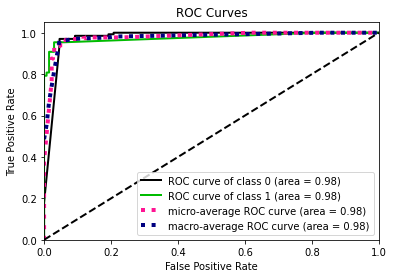

<Figure size 1400x1200 with 0 Axes>

In [ ]:
# Plot of ROC Curves per Class

from IPython.core.pylabtools import figsize
import scikitplot as skplt
import matplotlib.pyplot as plt
#y_test_labels = # ground truth labels
#predict_probas = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc(y_test_labels, predict_probas)
plt.figure(figsize=(14,12),dpi=100)
plt.show()

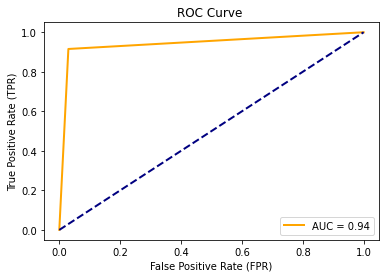

Area under curve (AUC):0.9427669345579793



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test_labels, y_predict) # need y_proba
roc_auc = roc_auc_score(y_test_labels, y_predict)   #need y_proba

plt.figure()
plt.plot(fprs, tprs, color='orange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve ')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

#### Incorrectly Predicted Images
As our final evaluation of our model, we will look at the images that were incorrectly predicted to see if there are any patterns.

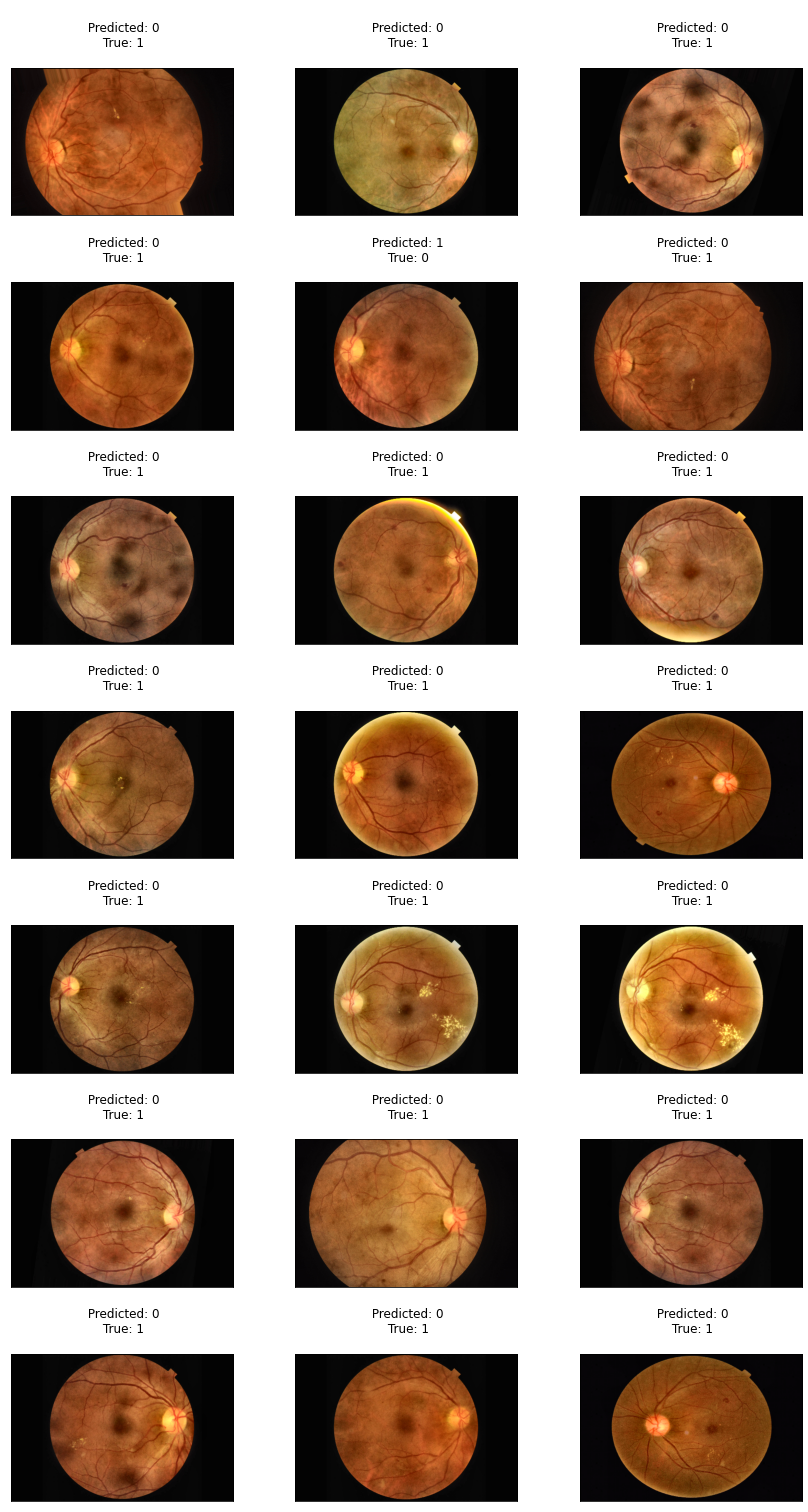

In [ ]:
import math

incorrect_photos = y_test_labels != y_predict

num_images = np.count_nonzero(incorrect_photos)
columns = 3
rows = math.ceil(num_images / columns)

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(12,3*rows))
axes = axes.flatten()

for i, image in enumerate(X_test[incorrect_photos]):
    axes[i].imshow(image, cmap='gray')

    # Get predicted label
    predicted = y_predict[incorrect_photos][i]

    # Get actual label
    actual = y_test_labels[incorrect_photos][i]
    
    #Get filename of image
    filenam = test_generator.filenames[i]
    x=filenam[8:]
    
    # Set the title of the subplot
    axes[i].set_title(f"\n IMAGE: {x} \n Predicted: {predicted}   True: {actual}\n")
    
    # Hide the x and y ticks to make 
    axes[i].set_xticks([]) 
    axes[i].set_yticks([])
    
fig.tight_layout()
# Hide unused subplots
for i in range(num_images, rows*columns):
    fig.delaxes(axes[i])

    plt.show()

In [ ]:
# Find all misclassified images in a given test set

MISCLASSIFIED = num_images

# Accuracy calculations
total = 264
num_correct = total - (MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print(f"Number of misclassified images = {MISCLASSIFIED}  out of {total}")

Accuracy: 0.9204545454545454
Number of misclassified images = 21  out of 264


# Concluding Remarks

This model provided great binary classification results for evaluating if eyes are healthy or show signs of Diabetic Retinopathy. We had 94% recall, 88% precision, and 88% test accuracy.
